# Final Project
Owner: Felix Brechtken
Date:  13.02.2021

#### Prequel:
Dear Peer,
in the following you will read my Data Science Capstone. I hope you will like it!
To ease reading I seperated the notebook in different sections each marked by headlines. Of course the headlines are inspired by the needs of the assignment and the Data Science Methodology.
1. Problem description
2. Usage of data
3. Methodology section
4. Data Collection and preparation
5. Visualization of data
6. Modelling
7. Visualization, Evaluation and discussion
8. Summary and Discussion

#### 1. Problem Description:
Due to my current work as an engineer in the german automotive industry, I have lots of contacts with electric vehicles and I am driving a new hybrid car myself. For summer, I am thinking about changing from a hybrid to a full electric car. The most interesting topic here is 'Where am I able to charge my car and do I have to expect changes in different parts of the town regarding the availibility of charging stations for business or holiday trips in towns like Berlin?'

#### 2. Usage of Data:
Although everyone talks about fast charging which is very expensive, a charging station with 7,5kW is absolutly sufficiant for me - you recharge around 80km of range per hour of charging. Therefore, the 7,5kW-charging station should be the goal of this analysis.
- I want to focus on the town of Berlin.
- I want to rate different parts of the town in their readiness for electric vehicles. Therefore I need the different parts of the town and information about the location and number of people who are living there.  
- As I expect to find differences I want to know, if there is a correlation between the monthly income of the people and the number of charging points. This should also give an impression, wether electric vehicles are more popular in more or less wealthy neighborhoods. For this I have downloaded an html table from rbb a german news company about the monthly income from https://www.rbb24.de/wirtschaft/beitrag/2019/01/einkommen-beitragsbemessungsgrenze-berlin-brandenburg.html.
- (please see Update) - I will download all charging stations for electric vehicles from Foursquare.
- To map all charging stations in the right neighborhood I need to connect each charging station to a neighborhood. In the table of charging station each station has a postal code mentioned. So I combine it with a dataframe of postal codes to neighborhoods by the german post.
Update:
During the coding I discovered, that the data provided by the Foursquare API about charging stations is very bad and decided to report it directly to Foursquare. 
Because I used the official data provided by legal authorities in a .csv I am sure, Foursquare will update it and within the next few weeks the project will look the same with 100% Foursquare data. https://www.bundesnetzagentur.de/DE/Sachgebiete/ElektrizitaetundGas/Unternehmen_Institutionen/HandelundVertrieb/Ladesaeulenkarte/Ladesaeulenkarte_node.html
##### Please notice: I have shown the usage of the Foursquare-API!

#### 3. Methodology section - How I want to solve the problem:
- Business understanding and the analytic approach are discussed above.
- The data requirements are also discussed above. 
- During my search I also discovered the data structure.
- First I will extract all data from the sources mentioned above.
- Afterwards I will visualize the data. I plan to make a Folium map and show all locations of charging stations.
- I also want to visualize the different parts of the town (propably in a table due to missing geojson-file) with the monthly income and number of people who live there.
- Afterwards I will try to find a correlation between 
    - The number of charging stations.
    - The average monthly income.
    - The number of people with high monthly income (complex value depending on german tax system)- roughly around 5700€ per month.
    - The number of people with low monthly income (below 2000€).
    - The density of people per km-square.
- The ease the use of my data I will preprocess it with a pipeline.
- I will cluster the parts of the town afterwards in three groups (EV-ready, EV-Possible, and Not-EV-ready).
- These results will be evaluated and discussed afterwards.
- If the evaluation shows a high reliability I will visualize the results. Then discuss them and conclude the report. If not I will try to change the model or gather new data.

### Start of the code - Installing and Importing of libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

In [3]:
import requests
#!conda install -c conda-forge lxml --yes
import lxml.html as lh
#!conda install -c conda-forge geocoder --yes
import geocoder
import pandas as pd
import numpy as np

In [4]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [5]:
import folium

In [80]:
import math

### 4. Data Collection and Data preparation

In [6]:
#read the excel for income in berlin from rbb
df_income = pd.read_excel('berlin_income.xlsx')
df_income.head()

,Unnamed: 0,Charlottenburg-Wilmersdorf,Steglitz-Zehlendorf,Friedrichshain-Kreuzberg,Pankow,Mitte,Tempelhof-Schöneberg,Treptow-Köpenick,Reinickendorf,Neukölln,Lichtenberg,Spandau,Marzahn-Hellersdorf
0,Below_2000,15.8,14.3,16.1,13.8,19.6,17.7,17.3,21.4,23.6,21.5,24.7,26.0
1,Above_5700,14.2,14.3,8.1,8.0,8.6,9.2,4.8,8.8,4.8,3.1,6.3,2.9
2,Average,3573.0,3553.0,3375.0,3358.0,3224.0,3194.0,3041.0,2984.0,2855.0,2810.0,2761.0,2647.0


In [7]:
#make the first column as index and delete unnamed 0
df_income.set_index('Unnamed: 0', inplace=True)
df_income.index.name=''
df_income.head()

,Charlottenburg-Wilmersdorf,Steglitz-Zehlendorf,Friedrichshain-Kreuzberg,Pankow,Mitte,Tempelhof-Schöneberg,Treptow-Köpenick,Reinickendorf,Neukölln,Lichtenberg,Spandau,Marzahn-Hellersdorf
,,,,,,,,,,,,
Below_2000,15.8,14.3,16.1,13.8,19.6,17.7,17.3,21.4,23.6,21.5,24.7,26.0
Above_5700,14.2,14.3,8.1,8.0,8.6,9.2,4.8,8.8,4.8,3.1,6.3,2.9
Average,3573.0,3553.0,3375.0,3358.0,3224.0,3194.0,3041.0,2984.0,2855.0,2810.0,2761.0,2647.0


In [8]:
# the foursquare API does not show enough charging stations, even when you try the word Ladesäule (german) or similar different words
# so i reported the issue and suggested them to also use the table i used from Bundesnetzagentur as our german legal authority.

In [9]:
#read the excel for income in berlin from rbb
df_charging = pd.read_excel('berlin_charging_stations.xlsx')
df_charging.head()

,Betreiber,Adresse,Postleitzahl Ort,Bundesland,Landkreis,Längengrad [DG],Breitengrad [DG],Inbetriebnahmedatum,Anschlussleistung [kW],Art der Ladeeinrichtung,...,Public Key1,Steckertypen2,P2 [kW],Public Key2,Steckertypen3,P3 [kW],Public Key3,Steckertypen4,P4 [kW],Spalte1
0,innogy eMobility Solutions GmbH,Boyenstr. 23,10115 Berlin,Berlin,Kreisfreie Stadt Berlin,13.368842,52.535955,40008.0,44.0,Normalladeeinrichtung,...,NaN,AC Steckdose Typ 2,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,innogy eMobility Solutions GmbH,Anklamer Str. 8,10115 Berlin,Berlin,Kreisfreie Stadt Berlin,13.395824,52.534398,40008.0,44.0,Normalladeeinrichtung,...,NaN,AC Steckdose Typ 2,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,innogy eMobility Solutions GmbH,Torstraße 165,10115 Berlin,Berlin,Kreisfreie Stadt Berlin,13.395841,52.529125,40282.0,44.0,Normalladeeinrichtung,...,NaN,AC Steckdose Typ 2,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,innogy eMobility Solutions GmbH,Gartenstraße 13,10115 Berlin,Berlin,Kreisfreie Stadt Berlin,13.391350,52.530483,40282.0,44.0,Normalladeeinrichtung,...,NaN,AC Steckdose Typ 2,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Allego GmbH,Habersaathstr. 34,10115 Berlin,Berlin,Kreisfreie Stadt Berlin,13.377620,52.531847,42725.0,22.0,Normalladeeinrichtung,...,NaN,AC Steckdose Typ 2,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df_inhabitants=pd.read_excel('berlin_inhabitants.xlsx')
df_inhabitants.set_index(df_inhabitants['Stadtteil'], inplace=True)
df_inhabitants.drop(['Stadtteil'], inplace=True, axis=1)
df_inhabitants.head()

,Einwohner,Flaeche
Stadtteil,,
Charlottenburg-Wilmersdorf,343592,6469
Steglitz-Zehlendorf,310071,10256
Friedrichshain-Kreuzberg,290386,2040
Pankow,409335,10322
Mitte,385748,3940


In [11]:
# get the coordinates of the town parts
# importing location of Pankow for testing
adress=('Pankow, Berlin')
geolocator = Nominatim(user_agent="charging_situation_in_berlin")
location = geolocator.geocode(adress)
latitude = location.latitude
longitude = location.longitude
print('The coordinates of Pankow are {}, {}.'.format(latitude, longitude))

The coordinates of Pankow are 52.5979174, 13.435316.


In [15]:
# sourcing the geo coordinates to every neighborhood
latitude=['']*df_income.shape[1]
longitude=['']*df_income.shape[1]
geolocator = Nominatim(user_agent="charging_situation_in_berlin")
i=0
for i in range(df_income.shape[1]):
    location = geolocator.geocode(adress)
    adress=(df_income.columns[i] + ', Berlin')
    latitude[i] = location.latitude
    longitude[i] = location.longitude
latitude[4]=latitude[4]-0.01

In [16]:
# appending the data as a new row in df_income
df_income.loc[len(df_income)] = latitude
df_income.loc[len(df_income)] = longitude
df_income

,Charlottenburg-Wilmersdorf,Steglitz-Zehlendorf,Friedrichshain-Kreuzberg,Pankow,Mitte,Tempelhof-Schöneberg,Treptow-Köpenick,Reinickendorf,Neukölln,Lichtenberg,Spandau,Marzahn-Hellersdorf
,,,,,,,,,,,,
Below_2000,15.800000,14.300000,16.100000,13.800000,19.600000,17.700000,17.300000,21.400000,23.600000,21.50000,24.700000,26.000000
Above_5700,14.200000,14.300000,8.100000,8.000000,8.600000,9.200000,4.800000,8.800000,4.800000,3.10000,6.300000,2.900000
Average,3573.000000,3553.000000,3375.000000,3358.000000,3224.000000,3194.000000,3041.000000,2984.000000,2855.000000,2810.00000,2761.000000,2647.000000
3,52.597917,52.507856,52.429205,52.501115,52.597917,52.517885,52.440603,52.417893,52.604763,52.48115,52.532161,52.535788
4,13.435316,13.263952,13.229974,13.444285,13.435316,13.404060,13.373703,13.600185,13.295287,13.43535,13.511893,13.197792
5,52.522523,52.507856,52.429205,52.501115,52.587917,52.517885,52.440603,52.417893,52.604763,52.48115,52.532161,52.535788
6,13.587663,13.263952,13.229974,13.444285,13.435316,13.404060,13.373703,13.600185,13.295287,13.43535,13.511893,13.197792


In [18]:
# let´s transpose the df
df_income = df_income.transpose()
df_income

,Below_2000,Above_5700,Average,3,4,5,6
Charlottenburg-Wilmersdorf,15.8,14.2,3573.0,52.597917,13.435316,52.522523,13.587663
Steglitz-Zehlendorf,14.3,14.3,3553.0,52.507856,13.263952,52.507856,13.263952
Friedrichshain-Kreuzberg,16.1,8.1,3375.0,52.429205,13.229974,52.429205,13.229974
Pankow,13.8,8.0,3358.0,52.501115,13.444285,52.501115,13.444285
Mitte,19.6,8.6,3224.0,52.597917,13.435316,52.587917,13.435316
Tempelhof-Schöneberg,17.7,9.2,3194.0,52.517885,13.404060,52.517885,13.404060
Treptow-Köpenick,17.3,4.8,3041.0,52.440603,13.373703,52.440603,13.373703
Reinickendorf,21.4,8.8,2984.0,52.417893,13.600185,52.417893,13.600185
Neukölln,23.6,4.8,2855.0,52.604763,13.295287,52.604763,13.295287
Lichtenberg,21.5,3.1,2810.0,52.481150,13.435350,52.481150,13.435350


In [19]:
# last we need to import a dataset to map the charging stations to a neighborhood
# we can do this by using the postal code
df_postcode = pd.read_excel('berlin_postal_code.xlsx')
df_postcode.drop_duplicates(subset=['PLZ_von'], inplace=True)
df_postcode

,PLZ_von,Stadtteil
0,10115,Mitte
1,10559,Mitte
2,13355,Mitte
3,10117,Mitte
4,10623,Mitte
...,...,...
239,13509,Reinickendorf
242,12154,Steglitz-Zehlendorf
243,13501,Spandau
244,14597,Spandau


In [20]:
# lets find the neighborhood for each charging station
df_charging['Neighborhood']=np.nan 
neighborhood=[]
for index, row in df_charging.iterrows():
    #print(index, '   ', int(row[2][0:5]))
    neighborhood.append(df_postcode['Stadtteil'].where(df_postcode['PLZ_von']==int(row[2][0:5])).dropna().iloc[0])
   
df_charging['Neighborhood']=neighborhood
df_charging.head()

,Betreiber,Adresse,Postleitzahl Ort,Bundesland,Landkreis,Längengrad [DG],Breitengrad [DG],Inbetriebnahmedatum,Anschlussleistung [kW],Art der Ladeeinrichtung,...,Steckertypen2,P2 [kW],Public Key2,Steckertypen3,P3 [kW],Public Key3,Steckertypen4,P4 [kW],Spalte1,Neighborhood
0,innogy eMobility Solutions GmbH,Boyenstr. 23,10115 Berlin,Berlin,Kreisfreie Stadt Berlin,13.368842,52.535955,40008.0,44.0,Normalladeeinrichtung,...,AC Steckdose Typ 2,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mitte
1,innogy eMobility Solutions GmbH,Anklamer Str. 8,10115 Berlin,Berlin,Kreisfreie Stadt Berlin,13.395824,52.534398,40008.0,44.0,Normalladeeinrichtung,...,AC Steckdose Typ 2,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mitte
2,innogy eMobility Solutions GmbH,Torstraße 165,10115 Berlin,Berlin,Kreisfreie Stadt Berlin,13.395841,52.529125,40282.0,44.0,Normalladeeinrichtung,...,AC Steckdose Typ 2,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mitte
3,innogy eMobility Solutions GmbH,Gartenstraße 13,10115 Berlin,Berlin,Kreisfreie Stadt Berlin,13.391350,52.530483,40282.0,44.0,Normalladeeinrichtung,...,AC Steckdose Typ 2,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mitte
4,Allego GmbH,Habersaathstr. 34,10115 Berlin,Berlin,Kreisfreie Stadt Berlin,13.377620,52.531847,42725.0,22.0,Normalladeeinrichtung,...,AC Steckdose Typ 2,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mitte


### Conclusion from raw data:

In [21]:
print('Total number of charging stations: ', len(df_charging))
print('Total number of neighborhoods: ', len(df_income))
print('Average income in neighborhoods reaches from ',  df_income['Average'].min(), '€ to ', df_income['Average'].max(), '€.')
print('\nNumber of charging stations in each neighborhood:\n', df_charging['Neighborhood'].value_counts())

Total number of charging stations:  651
Total number of neighborhoods:  12
Average income in neighborhoods reaches from  2647.0 € to  3573.0 €.

Number of charging stations in each neighborhood:
 Mitte                         160
Charlottenburg-Wilmersdorf    116
Tempelhof-Schöneberg           83
Pankow                         64
Friedrichshain-Kreuzberg       52
Steglitz-Zehlendorf            37
Treptow-Köpenick               37
Neukölln                       34
Spandau                        26
Lichtenberg                    22
Marzahn-Hellersdorf            12
Reinickendorf                   8
Name: Neighborhood, dtype: int64


### 5. Visualization of the Data

In [22]:
#lets show all charging stations around town
address = 'Berlin, Berlin'

geolocator = Nominatim(user_agent="charging_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Berlin are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of Berlin are 52.5170365, 13.3888599.


In [23]:
# create map of Berlin using latitude and longitude values
map_berlin = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_income.transpose().values.tolist()[3],df_income.transpose().values.tolist()[4], df_income.transpose().columns):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_berlin)  
    
map_berlin

In [24]:
# sort the neighborhoods in df_charging_counts and df_income
df_ccounts = df_charging['Neighborhood'].value_counts()
df_ccounts.sort_index(inplace=True)
#print(df_ccounts)

df_income.sort_index(inplace=True)

#df_income_number_combined = df_ccounts
#df_income_number_combined['average income']= df_income['Average']
#df_income_number_combined

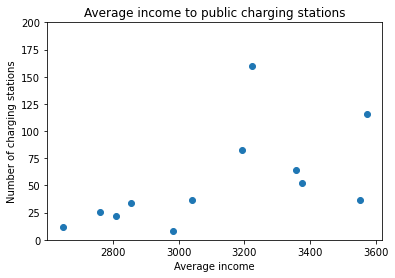

In [25]:
# this shows the distribution of charging stations per neighborhood
x=df_income['Average']
y=df_ccounts
plt.scatter(x, y) #, s=None, c=None), marker=list(df_income.index)) , cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=<deprecated parameter>, edgecolors=None, *, plotnonfinite=False, data=None, **kwargs)
#plt.title('Average income to number of charging stations in Berlin Neighborhoods')
plt.gca().update(dict(title='Average income to public charging stations', xlabel='Average income', ylabel='Number of charging stations', ylim=(0,200)))
plt.show()

In [26]:
# this looks pretty much like a linear regression. but first lets look at the outlier
print('The outlier is Berlin Center.')

The outlier is Berlin Center.


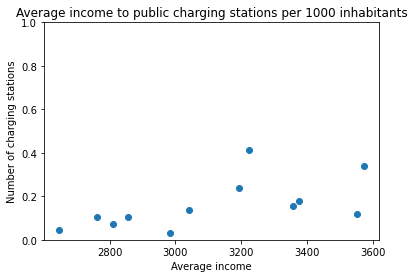

In [27]:
# What if we plot it in dependency of the inhabitants?
x=df_income['Average']
y=df_ccounts/df_inhabitants['Einwohner']*1000
plt.scatter(x, y) #, s=None, c=None), marker=list(df_income.index)) , cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=<deprecated parameter>, edgecolors=None, *, plotnonfinite=False, data=None, **kwargs)
#plt.title('Average income to number of charging stations in Berlin Neighborhoods per inhabitants')
plt.gca().update(dict(title='Average income to public charging stations per 1000 inhabitants', xlabel='Average income', ylabel='Number of charging stations', ylim=(0,1)))
plt.show()

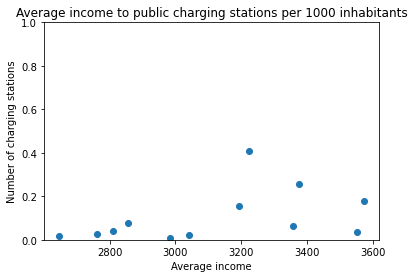

In [28]:
# What about the size of each part of the town?
x=df_income['Average']
y=df_ccounts/df_inhabitants['Flaeche']*10
plt.scatter(x, y) #, s=None, c=None), marker=list(df_income.index)) , cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=<deprecated parameter>, edgecolors=None, *, plotnonfinite=False, data=None, **kwargs)
#plt.title('Average income to number of charging stations in Berlin Neighborhoods per 1000m^2')
plt.gca().update(dict(title='Average income to public charging stations per 1000 inhabitants', xlabel='Average income', ylabel='Number of charging stations', ylim=(0,1)))
plt.show()

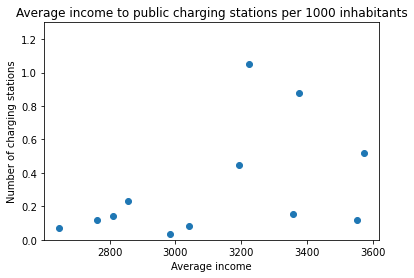

In [29]:
# What about the size of each part of the town?
x=df_income['Average']
y=df_ccounts/df_inhabitants['Flaeche']*10/df_inhabitants['Einwohner']*1000*1000
plt.scatter(x, y) #, s=None, c=None), marker=list(df_income.index)) , cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=<deprecated parameter>, edgecolors=None, *, plotnonfinite=False, data=None, **kwargs)
#plt.title('Average income to number of charging stations in Berlin Neighborhoods per 1000m^2')
plt.gca().update(dict(title='Average income to public charging stations per 1000 inhabitants', xlabel='Average income', ylabel='Number of charging stations', ylim=(0,1.3)))
plt.show()

#### Conclusion:
In all different scenarios, the average income in the part of the town seem to have a positive linear regression to the number of charging stations. Let´s try to put all this in one model.

### 6. Modeling

The goal is to find a relationship between
 - the average income
 - the number of charging stations
 - the number of people per neighborhood
 - the size of the neighborhood
 
 Because a positive correlation between the size of the neighborhood and the number of charging stations is expected, let´s talk about a
 number of charging stations per 1000 inhabitants per 1000m^2 dependency to the average income in a town.

In [30]:
# to prevent damage on dataframe i use a temp df for each df
df_itemp = df_income
df_ctemp = df_charging
df_ccounttemp = df_ccounts
df_inhabtemp = df_inhabitants

In [31]:
# lets try to build a linear regression without the space in which the people live
X=df_income.iloc[:,2:3]
# y will be the predicted value as charging stations per 1000m^2 per 1000 inhabitants
y = df_ccounts/df_inhabitants['Einwohner']*1000
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
pipe = Pipeline([('scaler', StandardScaler()), ('mode', LinearRegression())])
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
#Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())])
pipe.fit(X_train, y_train)

yhat=pipe.predict(X_test)
print('The score of the Linear Model with an input vector is ', pipe.score(X,y))
print('The result is not so good.')

The score of the Linear Model with an input vector is  0.2728618356394089
The result is not so good.


In [32]:
# X will be our input matrix
X=df_income.iloc[:,0:3]
# y will be the predicted value as charging stations per 1000m^2 per 1000 inhabitants
y = df_ccounts/df_inhabitants['Flaeche']*10/df_inhabitants['Einwohner']*1000

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
pipe = Pipeline([('scaler', StandardScaler()), ('mode', LinearRegression())])
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
#Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())])
pipe.fit(X_train, y_train)

yhat=pipe.predict(X_test)
print('The score of the Linear Model with 3x3 input matrix is ', pipe.score(X,y))
print('The result is better.')

The score of the Linear Model with 3x3 input matrix is  0.5968505956442951
The result is better.


### 7. Model evaluation and discussion

The R2-score is 0.3116068451639926
Mitte                         1.000000
Friedrichshain-Kreuzberg      0.833830
Charlottenburg-Wilmersdorf    0.495744
Tempelhof-Schöneberg          0.423434
Neukölln                      0.217880
Pankow                        0.143886
Lichtenberg                   0.136287
Steglitz-Zehlendorf           0.110520
Spandau                       0.109627
Treptow-Köpenick              0.076562
Marzahn-Hellersdorf           0.068300
Reinickendorf                 0.031936
dtype: float64


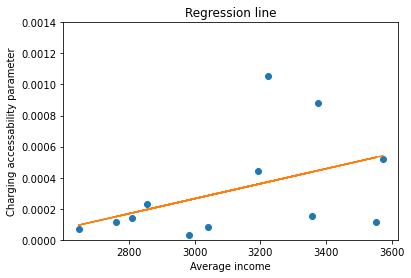

In [71]:
#show regression plot
# The R2-score should at least be 0.1
print('The R2-score is', sklearn.metrics.r2_score(y_test, yhat))
m,b = np.polyfit(X['Average'], y, 1)
plt.plot(x,y,'o')
plt.plot(x, m*x+b)
plt.gca().update(dict(title='Regression line', xlabel='Average income', ylabel='Charging accessability parameter', ylim=(0,0.0014)))
yreadiness = y/y.max()
yreadiness.sort_values(ascending=False, inplace=True)
print(yreadiness)

#### It seems, that the more central parts of the town have a higher density of charging stations. Lets see, if this is true:

In [85]:
# we set the location of the Brandenburger Tor as the center of the town and calculate the distance of every charging station to it.
address = 'Rathausstrasse 15, Berlin, Berlin'

geolocator = Nominatim(user_agent="charging_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Berlin are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Berlin are 52.518271799999994, 13.407830867048435.


In [86]:
# lets calculate the delta in longitude and latitude for each station
#dtotal is in kilometer with around 71km per 1° in germany

dlatitude=['']*len(df_charging)
dlongitude=['']*len(df_charging)
dtotal=['']*len(df_charging)
for index, row in df_charging.iterrows():
    dlatitude[index]=df_charging['Längengrad [DG]'][index]-longitude
    dlongitude[index]=df_charging['Breitengrad [DG]'][index]-latitude

    
dtotal = [71*math.sqrt(x1*x1 + x2*x2) for (x1, x2) in zip(dlatitude, dlongitude)]
#    dtotal=(dlongitude-longitude)^2+(dlatitude-latitude)^2

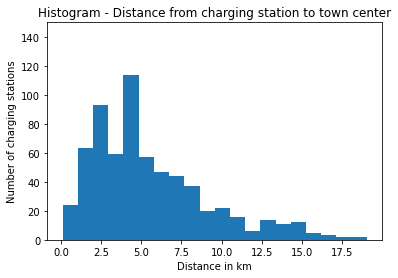

In [87]:
# now lets look at a histogram for dtotal
num_bins = 20 # <- number of bins for the histogram
plt.hist(dtotal, num_bins)
plt.gca().update(dict(title='Histogram - Distance from charging station to town center', xlabel='Distance in km', ylabel='Number of charging stations', ylim=(0,150)))
plt.show()

### 8. Result Section

So what did we find out?
We found the different parts of the town. To be mentioned here, they are all having between 200.000 and 400.000 inhabitants, so the sections are very big.
We saw a big difference between the monthly income of a neighborhood and the accessability of a charging station, which occured in a positive correlation.
The results made me thinking. The parts of the town which are closest to the center seems to have better acces. So I calculated the distance to the Townhall for each charging station.

It turned out that the density in the center of the town is the highest. Probably the differences within the different neighborhoods have a high seperation too if you go from the inner to the outer part.

### 8. Summary and Discussion of the results

#### Are the charging stations equally distributed?

In [48]:
yreadiness

Mitte                         1.000000
Friedrichshain-Kreuzberg      0.833830
Charlottenburg-Wilmersdorf    0.495744
Tempelhof-Schöneberg          0.423434
Neukölln                      0.217880
Pankow                        0.143886
Lichtenberg                   0.136287
Steglitz-Zehlendorf           0.110520
Spandau                       0.109627
Treptow-Köpenick              0.076562
Marzahn-Hellersdorf           0.068300
Reinickendorf                 0.031936
dtype: float64

The data analysis clearly showed big differences in the different parts of the town. This effect is showing a positive correlation between the the number of charging stations and the wealth (average income, percentage of people below 2000€ and percentage of people above above 5700€).  

The correlation is not too strong but the it is clearly positive. In reality this means people in wealthier parts of the town have access to more charging stations.

I expected even a much bigger difference, because wealthier people are more likely to drive the latest electric vehicle and are also living more likely in the center of the town, where the most charging stations are located.

For someone who drives an electric car I would recommend to move to Friedrichshain-Kreuzberg or as much in the center of the town as possible! But: Neighborhood 'Mitte' means Center and is very expensive. 

##### What would I do differently?
I would definitly try to gain a more detailed view of the town. The twelve categories as Regierungsbezirke (main parts of the town) where not sharp enough. In general I like the results and I think our future will be electric! I will keep this notebook stored and run it again in a year to see how much better we got in Germany.

Thanks for reading and greetings from Germany
Felix

#### Notebook written by: Felix Brechtken, 14.02.2021